# Object Detection(Car Detection)




### DOMAIN: 
Automotive , Surveillance
### CONTEXT: 
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is 
predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of 
the car, type, colour, number plates etc
### DATA DESCRIPTION: 
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing 
images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 
2012 Tesla Model S or 2012 BMW M3 coupe
‣ Train Images: Consists of real images of cars as per the make and year of the car. 
‣ Test Images: Consists of real images of cars as per the make and year of the car.
‣ Train Annotation: Consists of bounding box region for training images.
‣ Test Annotation: Consists of bounding box region for testing images.
Dataset has been attached along with this project. Please use the same for this capstone project
Dataset: Original dataset link for your reference only: https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder
### REFERENCE: 
3D Object Representations for Fine-Grained Categorisation, Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei 4th IEEE 
Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.
### PROJECT OBJECTIVE: 
Design a DL based car identification model

In [ ]:
%tensorflow_version 2.x
#%tensorflow_version 1.x

In [ ]:
# Lets check version of tensor flow and keras installed 

import tensorflow
print(tensorflow.__version__)

2.8.0


In [ ]:
import keras
print(keras.__version__)

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


All the above versions libraries are required for the Third party implementation we are goin to use

## Legend

 ### Insights/inferences/results have been displayed post each step

In [ ]:
# Lets check if we are connected to GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


## 1.0 Basic Config & Settings

### 1.1 Import necessary libraries

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import statistics as stats
sns.set(color_codes=True)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#Last import allows multiple outputs from one cell
import warnings
# Initialize the random number generator
import random
random.seed(0)

#Additional libs
import matplotlib.patches as patches


In [ ]:
# Useful Configuration/Setting

# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

#Setting to shows all entries in array displayed
np.set_printoptions(threshold=sys.maxsize)

### 1.2 Set Necessary variables

In [ ]:
# Read The Data Set


images_path = "/content/drive/MyDrive/Capstone/Car Images/Car Images/"

#Lets note here that our images are structred as folders.Each folder is a cart type
#Corresponding folder will contain images of THAT car  type
#We have a seperate folder for Train and Test IMages

In [ ]:
# Variables required for model Building

#images_height=300
#images_width=300

## 3.0 Retrive Pickled  Validation Data 


In [ ]:
X_Batch_Class_Input=np.load("/content/drive/MyDrive/Capstone/Pickled_Info/X_Batcht_ClassIp.npy")
Y_Batch_Class_Output=np.load("/content/drive/MyDrive/Capstone/Pickled_Info/Y_Batch_ClassOp.npy")

In [ ]:
X_Batch_Class_Input.shape
Y_Batch_Class_Output.shape

(1600, 300, 300, 3)

(1600, 196)

In [ ]:
X_Batch_Reg_Input = np.load("/content/drive/MyDrive/Capstone/Pickled_Info/X_Batcht_RegIp.npy")
Y_Batch_Reg_Output  = np.load("/content/drive/MyDrive/Capstone/Pickled_Info/Y_Batch_RegOp.npy")

In [ ]:
X_Batch_Reg_Input.shape
Y_Batch_Reg_Output.shape

(1600, 128, 128, 3)

(1600, 4)

## 4.0 Build Model with Pre-trained weights

In [ ]:
import pickle

# open a file, where you stored the pickled class indices
file = open('/content/drive/MyDrive/Capstone/Pickled_Info/Classindices.pkl', 'rb')

# dump information to that file
classDict = pickle.load(file)

In [ ]:
# Create reg model and load its weights
# Lets build the model

from keras.applications.mobilenet import MobileNet
from keras.models import Model,load_model
from keras.layers import Conv2D, Reshape,Flatten,Dense,Dropout,GlobalAveragePooling2D,BatchNormalization,Input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

ALPHA = 1.0

def create_reg_od_model(trainable=True):
    regODModel = MobileNet(input_shape=(128, 128, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in regODModel.layers:
        layer.trainable = trainable
    
    # Add new top layer for Regression Head
    regODModelOP = regODModel.layers[-1].output
    regODModelOP = Flatten()(regODModelOP)
    regODModelOP = Dense(units=4,name="box_output")(regODModelOP) # These are the 4 predicted coordinates of one BBox
    #boxPredicModel = Dense(units=4)(boxPredicModel) # These are the 4 predicted coordinates of one BBox 
    return Model(inputs=regODModel.input, outputs=regODModelOP)

In [ ]:

#from tensorflow.keras import layers

def create_classifiction_model(num_classes=196,IMG_SIZE=300):
  inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  model = keras.applications.efficientnet.EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  #for layer in model.layers[-20:]:
   # if not isinstance(layer, BatchNormalization):
    #  layer.trainable = True
  
  
  # Rebuild top
  x = GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = BatchNormalization()(x)

  top_dropout_rate = 0.5
  x = Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = Dense(num_classes, activation="softmax", name="class_output")(x)

  return Model(inputs, outputs)

In [ ]:
def create_final_baseline_model(trainable=True):

    #inputToRegModel =Input((128,128,3))
    # Load weights from saved reg model
    regODModel=create_reg_od_model(False)
    regODModel.load_weights('/content/drive/MyDrive/Capstone/Pickled_Info/RegODModel_bestWieghts_128.h5')
    classModel=create_classifiction_model()
    classModel.load_weights('/content/drive/MyDrive/Capstone/Pickled_Info/classification_best_weights_300_sync.h5')


    #regODModel.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE
    return Model(inputs=[regODModel.input,classModel.input], outputs=[regODModel.output,classModel.output])
    #return regODModel



In [ ]:
# Define evaluation metric

def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection
    # rk - again to repeat we know why he has minues , taken 2 times 

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)# rounded to 4 
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou
    # this is one number for the whole model

In [ ]:
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou
# This is a wrapper funcction

In [ ]:
#Initialize the model and print summary

model = create_final_baseline_model(False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() # Print summary

43950080/43941136 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding

In [ ]:
# For classification we will have cateogirical crossentropy

# For the bouding boxes we will have mean squared error

losses = {

    "box_output":"mean_squared_error",

    "class_output": "categorical_crossentropy"

        }


# If you think that detection is harder then the classification then you can
# Try assinging it more weight
loss_weights = {

    "box_output": 1.0,

    "class_output": 1.0
                }


# Set the Metrics

# For the class labels we want to know the Accuracy
# And for the bounding boxes we need to know the Mean squared error

custommetrics = {

    "box_output": IoU,

    "class_output": 'accuracy'

        }


In [ ]:
#Compile the model

model.compile(loss=losses, optimizer='adam', metrics=custommetrics,loss_weights=loss_weights)
#model.compile(loss=losses, optimizer='SGD', metrics=custommetrics,loss_weights=loss_weights)

In [ ]:
# The block below is commented because we will not be trainig this model
# We will simply load pre-trained weights , compile and run an evaluation on Validation data

#Training the model
#Fit the model to the dataset

#Use early stopping,fit the model,give train data - training features and labels,batch size: 32 contd...
#...epochs: 10,give validation data - testing features and labels

# Use earlystopping
#es = EarlyStopping(monitor ="val_loss", min_delta = 0.1, patience=20)
#mc = ModelCheckpoint('/content/drive/MyDrive/Capstone/Pickled_Info/BaselineModel.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# If val_iou does not increase by 001 in 5 epochs , stop
# Fit the model
'''history=model.fit(
          x= {"input_3":X_Train_MobileNet,"input_4":X_Train_MobileNet},
          y={"box_output":Y_Train_MobileNet_BoxInput,
             "class_output":Y_Train_MobileNet_ClassInput
          },
           validation_data=( {"input_3":X_Test_MobileNet,"input_4":X_Test_MobileNet} ,
              {"box_output":Y_Test_MobileNet_BoxInput,"class_output":Y_Test_MobileNet_ClassInput}), epochs=3, batch_size=700)'''

In [ ]:
######################################## Evaluate Model ############################################################

- Evaluating on 1600 records at one shot causes **memory failures.**
- We will be dividing the data into sub batches and running evaluation on each batch
The
- The final scores will be **avg on scores over all batches**

In [ ]:
# Batch 1

#Final loss and accuracy
model.evaluate({"input_1":X_Batch_Reg_Input[0:500],"input_2": X_Batch_Class_Input[0:500]},
               {"box_output":Y_Batch_Reg_Output[0:500],"class_output":Y_Batch_Class_Output[0:500]})

16/16 [==============================] - 17s 166ms/step - loss: 37.1880 - box_output_loss: 36.0693 - class_output_loss: 1.1186 - box_output_IoU: 0.8372 - class_output_accuracy: 0.6960


[37.187984466552734,
 36.0693473815918,
 1.118638277053833,
 0.837218701839447,
 0.6959999799728394]

In [ ]:
# Batch 2

#Final loss and accuracy
model.evaluate({"input_1":X_Batch_Reg_Input[501:1000],"input_2": X_Batch_Class_Input[501:1000]},
               {"box_output":Y_Batch_Reg_Output[501:1000],"class_output":Y_Batch_Class_Output[501:1000]})

16/16 [==============================] - 3s 162ms/step - loss: 37.6165 - box_output_loss: 36.5696 - class_output_loss: 1.0469 - box_output_IoU: 0.8343 - class_output_accuracy: 0.7094


[37.616458892822266,
 36.56955337524414,
 1.0469087362289429,
 0.8343437314033508,
 0.7094188332557678]

In [ ]:
# Batch 3

#Final loss and accuracy
model.evaluate({"input_1":X_Batch_Reg_Input[1000:1600],"input_2": X_Batch_Class_Input[1000:1600]},
               {"box_output":Y_Batch_Reg_Output[1000:1600],"class_output":Y_Batch_Class_Output[1000:1600]})

19/19 [==============================] - 3s 160ms/step - loss: 6291.1816 - box_output_loss: 6290.0723 - class_output_loss: 1.1087 - box_output_IoU: 0.7971 - class_output_accuracy: 0.7050


[6291.181640625,
 6290.072265625,
 1.108707308769226,
 0.7970947623252869,
 0.7049999833106995]

In [ ]:
##################################################### End #########################################################

## 5.0 Final Accuracy & IOU Scores

In [ ]:
IOU = (0.837218701839447 + 0.8343437314033508 +0.7970947623252869)/3
Accuracy = (0.6959999799728394 + 0.7094188332557678 + 0.7049999833106995)/3

print('IOU of the Custom Baseline model is : ',IOU)
print('Accuracy of the Custom Baseline model is : ',Accuracy)

IOU of the Custom Baseline model is :  0.8228857318560282
Accuracy of the Custom Baseline model is :  0.7034729321797689


## 6.0 Predict

In [ ]:
# Take some sample image and predict

#region=model.predict(X_Test_MobileNet[2345].reshape(1,128,128,3)) # Predict the BBox

image1 =X_Batch_Reg_Input[200].reshape(1,128,128,3)
image1.shape
image2 =X_Batch_Class_Input[200].reshape(1,300,300,3)
image2.shape
region=model.predict({"input_1":image1,"input_2":image2}) # Predict the BBox

(1, 128, 128, 3)

(1, 300, 300, 3)

In [ ]:
type(region)

In [ ]:
label=np.argmax(region[1][0])

In [ ]:
# Predicted label
label

61

In [ ]:

# list out keys and values separately
key_list = list(classDict.keys())
val_list = list(classDict.values())
 
# print key with val 100
position = val_list.index(12)
print(key_list[position])

Audi 100 Wagon 1994


In [ ]:
# Actual Label

np.argmax(Y_Batch_Class_Output[200])

61

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


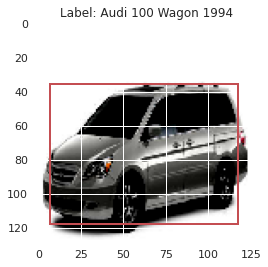

In [ ]:
# Lets visually display any two train data samples

# View any one sample of prepared Train Data 
im=X_Batch_Reg_Input[200]
# Show resized image with Box
fig,ax = plt.subplots(1)
ax.imshow(im)
res_x0,res_y0,res_x1,res_y1,=region[0][0]
rect = patches.Rectangle((res_x0, res_y0), res_x1 - res_x0, res_y1 - res_y0, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.title.set_text('Label: '+ key_list[position])

plt.show()


In [ ]:
##############################################END#################################################################